<a href="https://colab.research.google.com/github/ese-ada-lovelace-2024/dl-module-coursework-2-esemsc-sn2824/blob/master/Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Data Reconstruction with Neural Networks

This notebook demonstrates an end-to-end workflow for loading, exploring, and reconstructing corrupted weather data recorded daily for a European city over four decades. You’ll progress through:

1. Data loading & visualization  
2. PyTorch data preparation  
3. Neural network design & training  
4. Results analysis & next steps  


The data contains a number of relevant weather variables, recorded daily for a European city during a period of four decades.

However, this dataset has been corrupted, and some of the daily measurements are now missing. The goal of this assessment is to develop a neural network architecture that can recover the missing measurements!

<br>

---

<br>

The dataset has been saved as `.csv` files and has been separated into a `training_set/` folder and a `test_set.csv` file. The `training_set/` contains data for three of the four decades, separated in one individual file per decade:

- `training_set_0.csv` contains corrupted data for the first decade; `training_set_0_nogaps.csv` contains the same data before it was corrupted.
- `training_set_1.csv` contains corrupted data for the second decade; `training_set_1_nogaps.csv` contains the same data before it was corrupted.
- `training_set_2.csv` contains corrupted data for the third decade; `training_set_2_nogaps.csv` contains the same data before it was corrupted.

The `test_set.csv` file contains the remaining decade; this data is corrupted and contains gaps, but we have lost access to the data before corruption.

The architecture that you design in this assessment should use the data contained inside the `training_set` in order to recover the missing information in the data in `test_set.csv`. Note that decades `0`, `1`, and `2` are not necessarily consecutive.

Inside each of the `.csv` files, you will find the following columns:

- `date`
- `cloud_cover`
- `sunshine`
- `global_radiation`
- `max_temp`
- `mean_temp`
- `min_temp`
- `precipitation`
- `pressure`

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## Step 1: Load and Visualize the Data

Load the training and test CSV files (both corrupted and original). Then:

- Display line plots of each variable to highlight trends and corruption.  
- Plot histograms for every variable before and after corruption.  


Mounting my Google Drive

In [298]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the Necessary Libraries

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from pycm import *
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm', 'axes', 'random', 'std', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Loading the Train and Testing Dataset

In [300]:
train_set0_corrupted = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/training_set/training_set_0.csv")
train_set0_uncorrupted = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/training_set/training_set_0_nogaps.csv")
train_set1_corrupted = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/training_set/training_set_1.csv")
train_set1_uncorrupted = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/training_set/training_set_1_nogaps.csv")
train_set2_corrupted = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/training_set/training_set_2.csv")
train_set2_uncorrupted = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/training_set/training_set_2_nogaps.csv")


test_set = pd.read_csv("/content/drive/MyDrive/dl-module-coursework-2-esemsc-sn2824-master/test_set.csv")

Preview of columns and what the data looks like

In [301]:
train_set0_corrupted.head(3)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,0,4.0,0.2,10.6,2.1,-1.3,-4.2,0.0,101282.7
1,1,2.0,6.7,58.8,11.4,-2.1,-6.0,0.2,102455.7
2,2,7.9,-0.0,5.7,9.6,NaN,-5.8,9.9,101920.4


Decade 1 - Training dataset 0

https://www.kaggle.com/code/melissamonfared/stock-price-prediction-lstm?scriptVersionId=197676147&cellId=30

https://www.kaggle.com/code/melissamonfared/stock-price-prediction-lstm?scriptVersionId=197676147&cellId=32

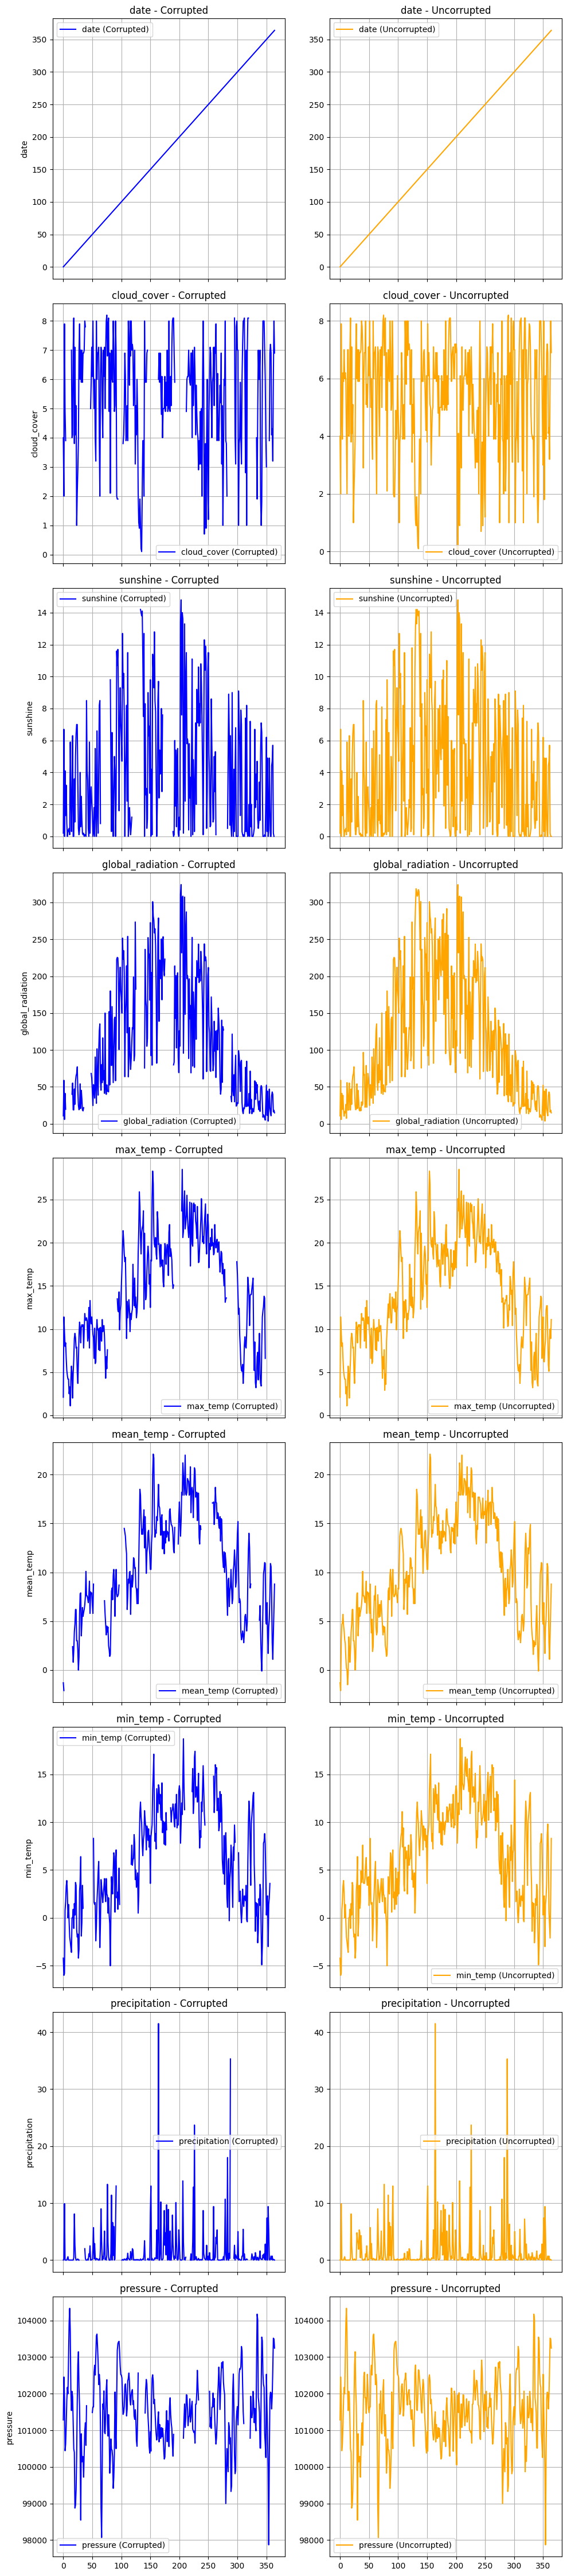

In [302]:
df1 = train_set0_corrupted[train_set0_corrupted["date"].isin(range(0, 365))]
df2 = train_set0_uncorrupted[train_set0_uncorrupted["date"].isin(range(0, 365))]


# Setting up subplots
num_variables = len(df1.columns)  # Number of variables (columns)
fig, axes = plt.subplots(num_variables, 2, figsize=(10, 5 * num_variables), sharex=True)

# Plot each variable for both datasets
for i, column in enumerate(df1.columns):
    # Dataset 1 plot
    ax1 = axes[i, 0]
    ax1.plot(df1.index, df1[column], label=f"{column} (Corrupted)", color='blue')
    ax1.set_title(f"{column} - Corrupted")
    ax1.set_ylabel(column)
    ax1.legend()
    ax1.grid()

    # Dataset 2 plot
    ax2 = axes[i, 1]
    ax2.plot(df2.index, df2[column], label=f"{column} (Uncorrupted)", color='orange')
    ax2.set_title(f"{column} - Uncorrupted")
    ax2.legend()
    ax2.grid()

# Adjust layout
fig.tight_layout()
plt.show()


Testing Dataset - Plotting the Line Plots

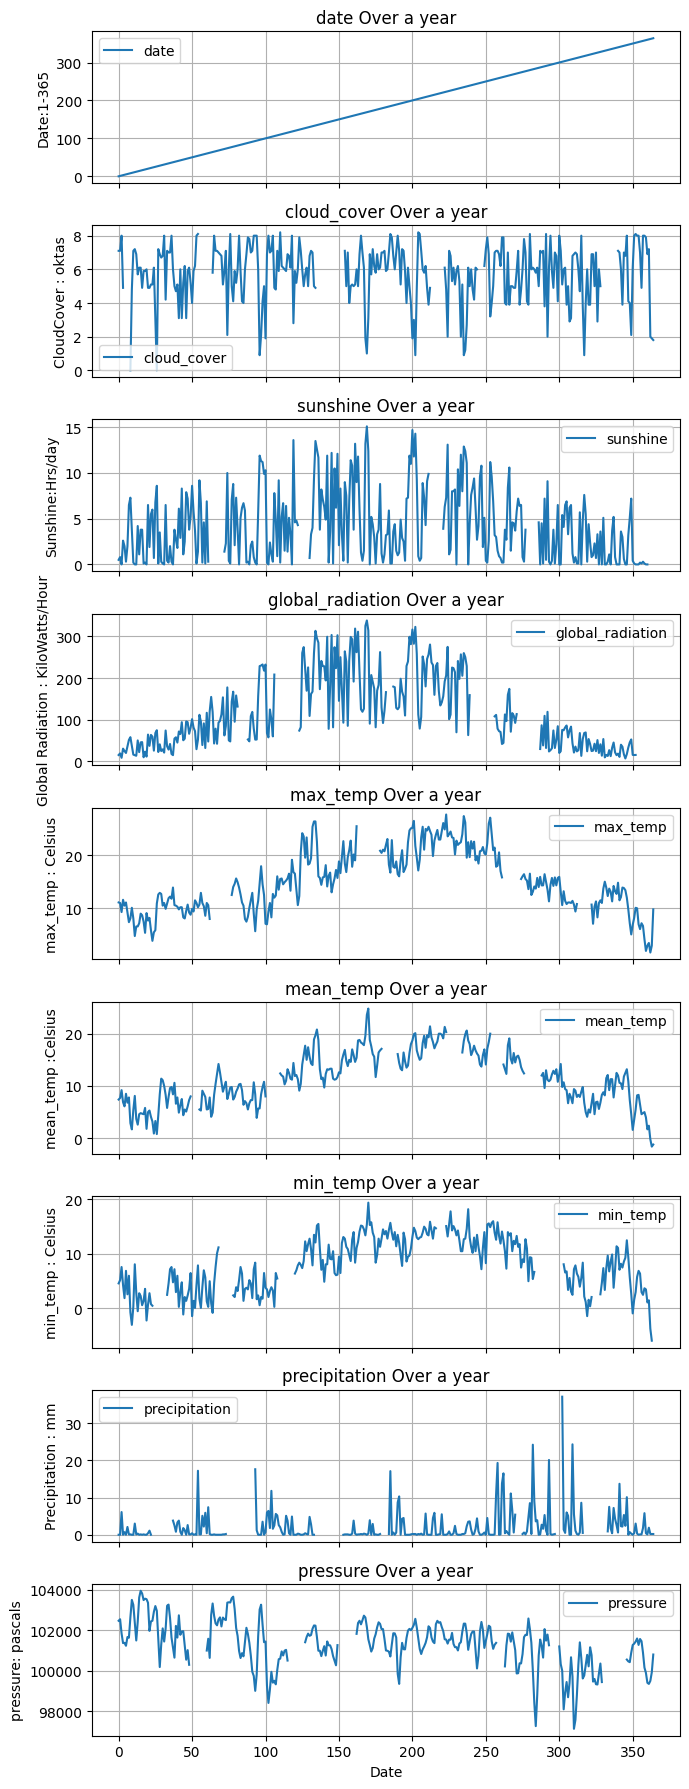

In [303]:
df1 = test_set[test_set["date"].isin(range(0, 365))]

# Setting up subplots
num_variables = len(df1.columns)  # Number of variables (columns)
fig, axes = plt.subplots(num_variables, 1, figsize=(7, 2 * num_variables ), sharex=True)
list_of_y_axis = ["Date:1-365", "CloudCover : oktas", "Sunshine:Hrs/day", "Global Radiation : KiloWatts/Hour", "max_temp : Celsius", "mean_temp :Celsius", "min_temp : Celsius", "Precipitation : mm", "pressure: pascals"]
# Plot each variable in a separate subplot
for i, column in enumerate(df1.columns):
    ax = axes[i] if num_variables > 1 else axes  # Handle single subplot case
    ax.plot(df1.index, df1[column], label=column)
    ax.set_title(f"{column} Over a year")
    plt.xlabel('Date')
    ax.set_ylabel(list_of_y_axis[i])
    ax.legend()
    ax.grid()
# Date over Time

# Adjust layout
fig.tight_layout()
plt.show()


Statistical description of the Test Data

In [304]:
test_set.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
count,3652.000000,3117.000000,3088.000000,3092.000000,2969.000000,3055.000000,3065.000000,3089.000000,3045.000000
mean,1825.500000,5.286173,4.420402,121.215362,15.584439,11.864452,7.924111,1.813079,101543.529918
std,1054.385919,2.005485,3.975984,88.795834,6.384985,5.708833,5.216791,3.687227,1061.652407
min,0.000000,0.000000,0.000000,0.800000,0.200000,-2.200000,-6.600000,0.000000,97143.700000
25%,912.750000,4.000000,0.600000,43.900000,10.700000,7.600000,4.000000,0.000000,100919.400000
50%,1825.500000,5.900000,3.600000,98.750000,15.400000,11.700000,8.100000,0.200000,101623.000000
75%,2738.250000,7.000000,7.200000,187.325000,20.500000,16.500000,12.100000,1.700000,102246.000000
max,3651.000000,8.300000,15.700000,354.400000,37.800000,28.400000,20.400000,37.100000,104322.500000


### Inference 🌧

From the summary table of the test set, I have seen the following statistical patterns :    

### Comment on Sample Size :
1. **Sample Size**:
   - Each column represents data points over a range of 3652 days (approximately 10 years), though some columns have missing values (e.g., "cloud_cover" has 3117 entries while "mean_temp" has 3055).

### Temperature Observation:
2. **Maximum Temperature**:
   - Average maximum value: **15.58°C**.
   - Values range from **0.2°C** (minimum) to **37.8°C** (maximum).

3. **Mean Temperature (`mean_temp`)**:
   - Mean value: **11.86°C**, which indicates a moderate weather.
   - Negative values also exist, showing that the weather seems cold in season.

4. **Minimum Temperature (`min_temp`)**:
   - Average minimum temperature is **7.92°C**, with a minimum recorded value of **-6.6°C**,which indicates cold weather conditions.

### Precipitation:
5. **Precipitation**:
   -About 50% of the time, the days have no precipitation (50th percentile = **0 mm**), indicating significantly dry days.

### Global Radiation and Sunshine:
6. **Global Radiation**:
   - The IQR (43.9 W/m² to 187.3 W/m²) shows decent variability in radiation intensity.

7. **Sunshine Hours (`sunshine`)**:
   - The average sunshine duration is **4.42 hours/day**, with a maximum of **15.7 hours/day**.
   - Many days likely have minimal sunshine (25th percentile = **0.6 hours/day**).

### Cloud Cover:
8. **Cloud Cover**:
   - The data indicates a mix of clear and cloudy days, with a slightly higher proportion of partly cloudy skies (median = **5.9 units**).

### Pressure:
9. **Pressure**:

   - Not much variability in pressure (as std: **1061.65 Pa**) is relatively small, suggesting stable weather pressure patterns overall.




*Assuming that the inference is persistant across all the decades, I would do it individually, and check year-by year difference with more time*

Illustrating all the missing values in the datasets of all decades

In [305]:
datasets = {
    "Corrupted Train 0": train_set0_corrupted,
    "Corrupted Train 1": train_set1_corrupted,
    "Corrupted Train 2": train_set2_corrupted,
    "Test Dataset" : test_set
}

missing_values_summary = {}
for i, dataset_name in enumerate(datasets):  # i is the index, dataset_name is the key
    dataset = datasets[dataset_name]  # Access the actual DataFrame using the key
    missing_values_summary[dataset_name] = dataset.isnull().sum()  # Compute missing values

# Convert the results to a DataFrame for better presentation
missing_values_df = pd.DataFrame(missing_values_summary)
print("**Number of Missing Values across all Corrupted data**")

# Display the results
print(missing_values_df)



**Number of Missing Values across all Corrupted data**
                  Corrupted Train 0  Corrupted Train 1  Corrupted Train 2  \
date                              0                  0                  0   
cloud_cover                     640                596                606   
sunshine                        587                592                509   
global_radiation                623                599                574   
max_temp                        602                610                582   
mean_temp                       606                577                558   
min_temp                        601                576                564   
precipitation                   541                554                636   
pressure                        576                605                589   

                  Test Dataset  
date                         0  
cloud_cover                535  
sunshine                   564  
global_radiation           560  
max_temp 

Plotting a histogram for **each Variable** , across **all decades** in the dataset before and after corruption

Decade 1 - Training Dataset

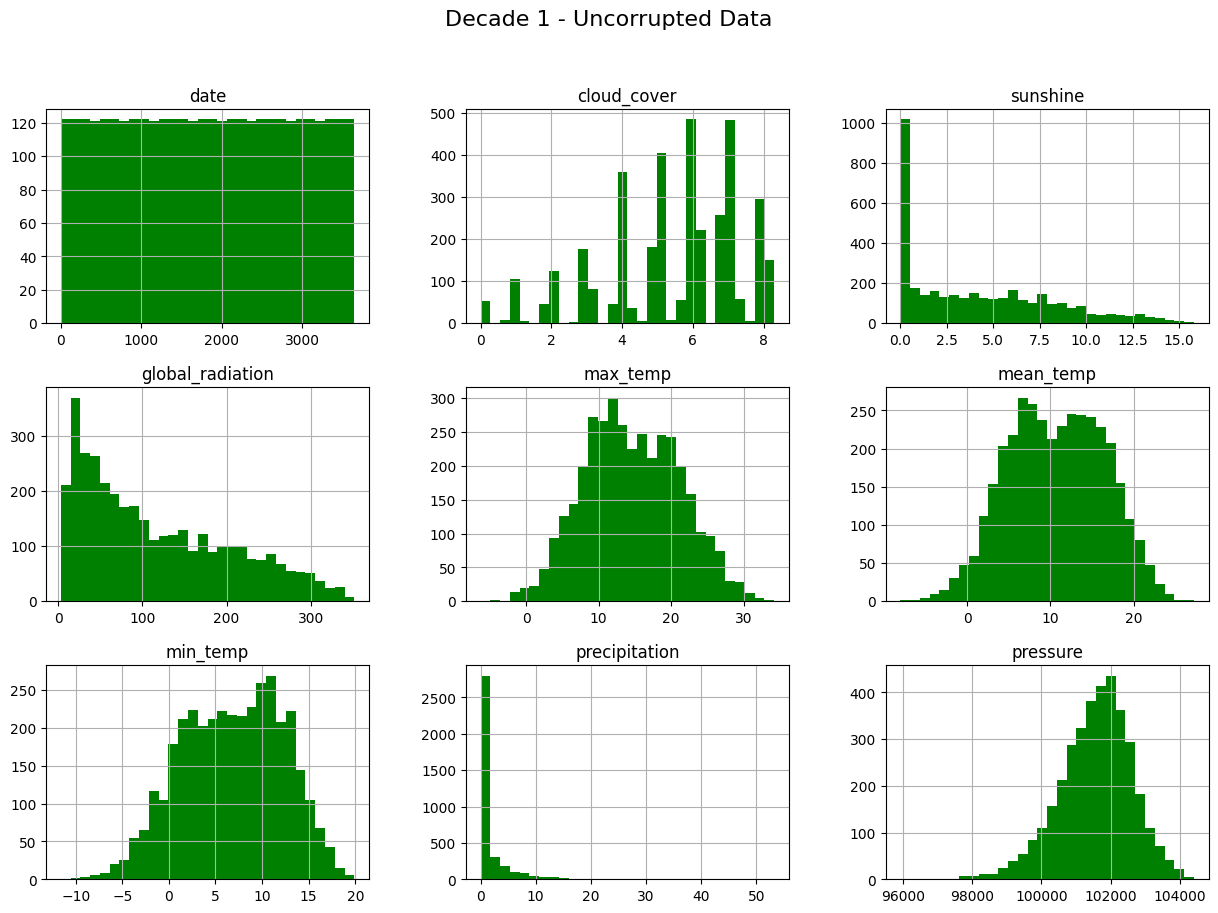

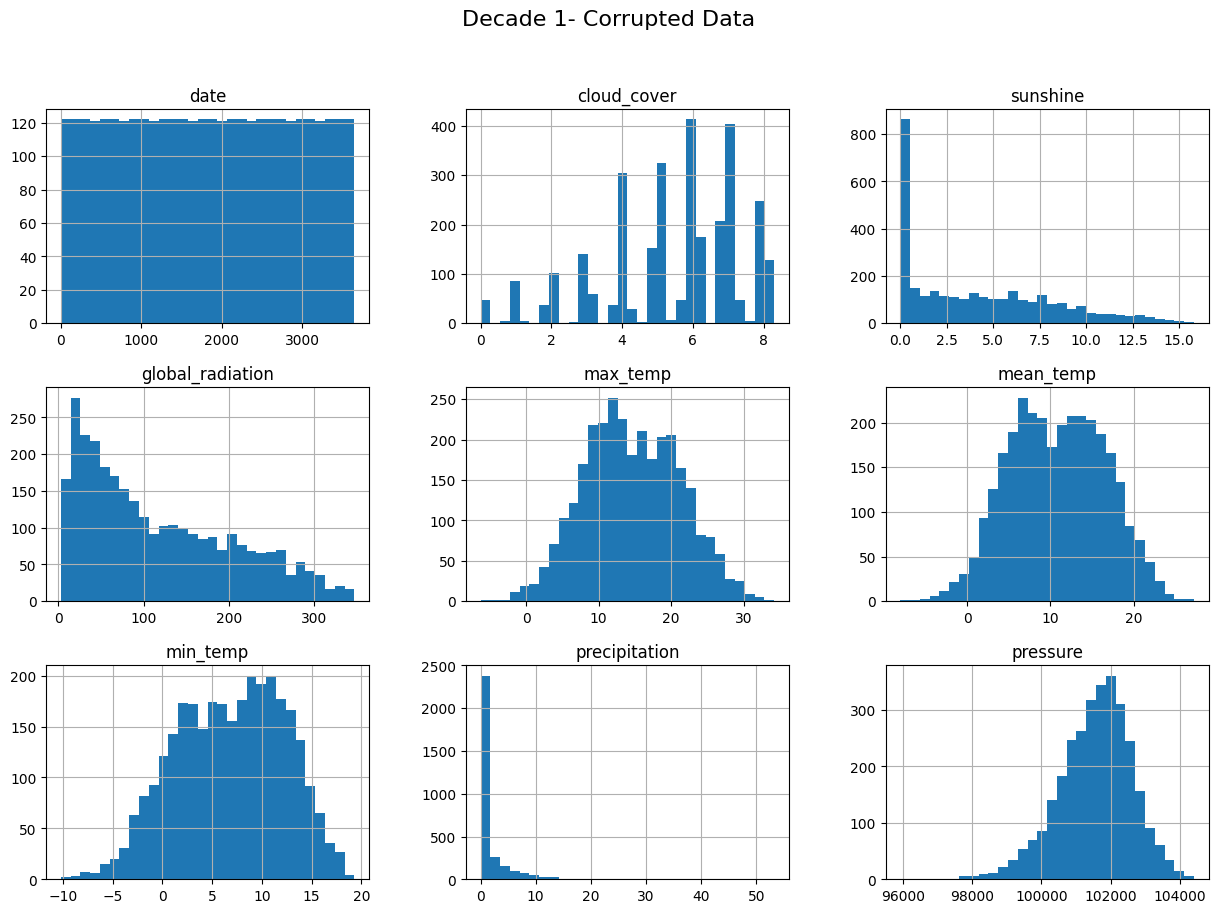

In [306]:
train_set0_uncorrupted.hist(bins=30, figsize=(15, 10), color = "green")
plt.suptitle('Decade 1 - Uncorrupted Data', fontsize=16)
plt.show()
train_set0_corrupted.hist(bins=30, figsize=(15, 10))
plt.suptitle('Decade 1- Corrupted Data', fontsize=16)
plt.show()

Decade 2 - Training Dataset

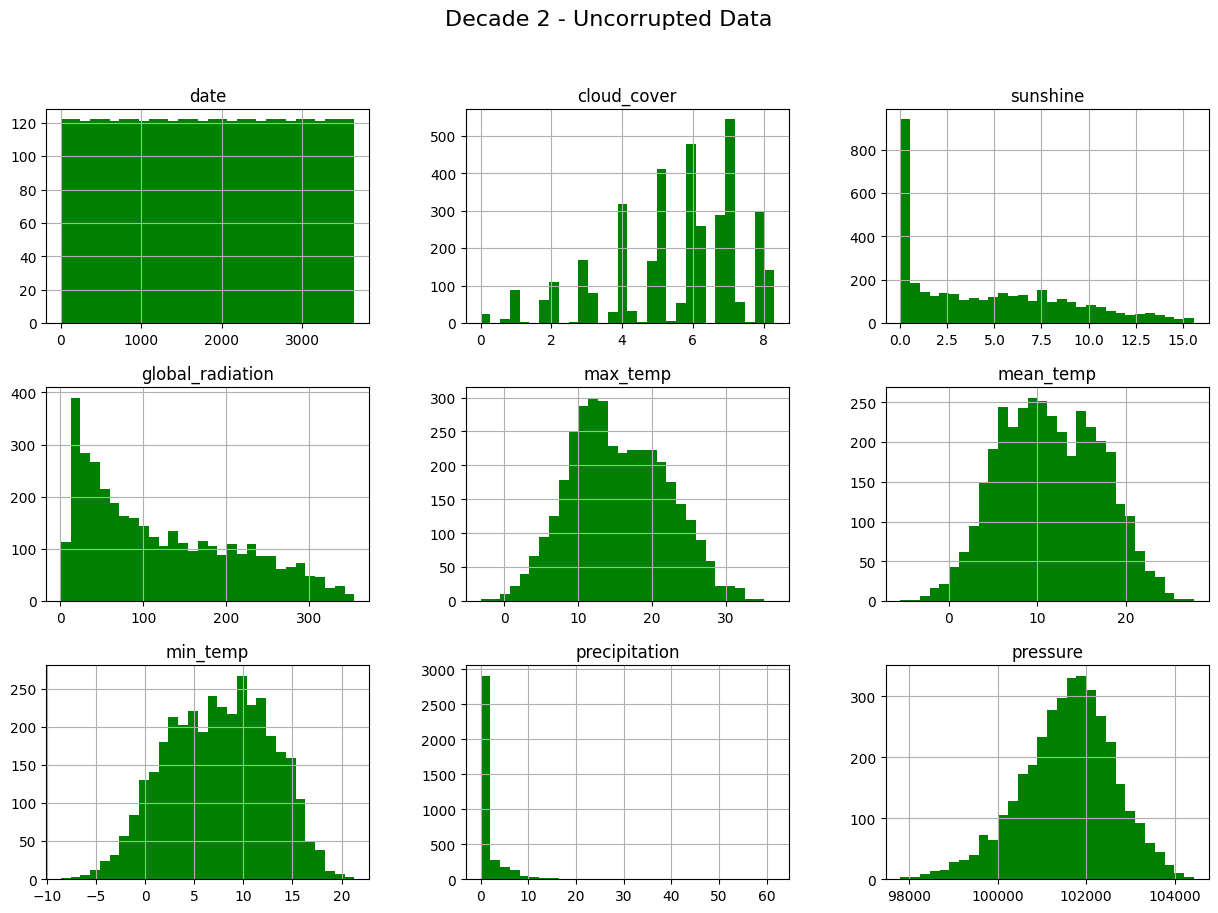

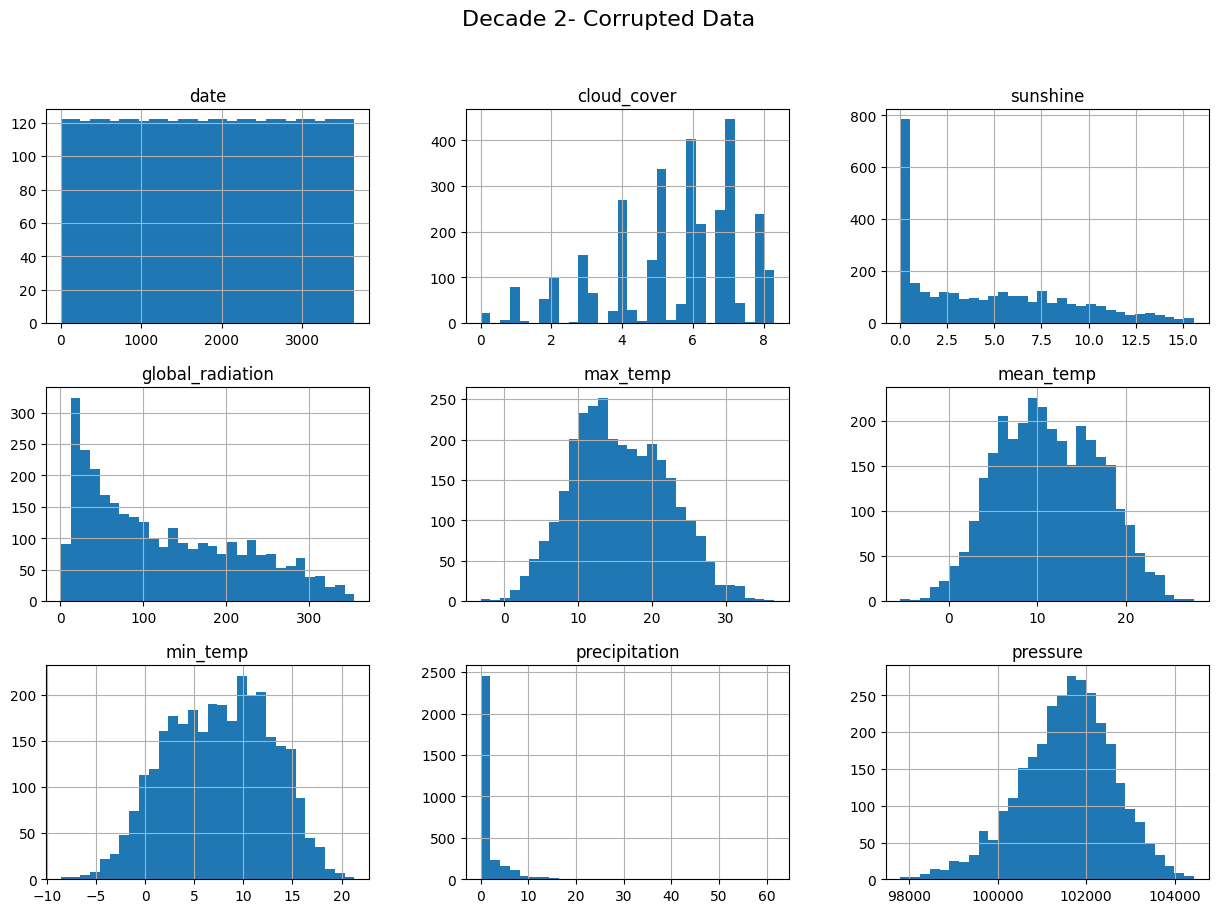

In [307]:
train_set1_uncorrupted.hist(bins=30, figsize=(15, 10), color = "green")
plt.suptitle('Decade 2 - Uncorrupted Data', fontsize=16)
plt.show()
train_set1_corrupted.hist(bins=30, figsize=(15, 10))
plt.suptitle('Decade 2- Corrupted Data', fontsize=16)
plt.show()

Decade 3 - Training Dataset

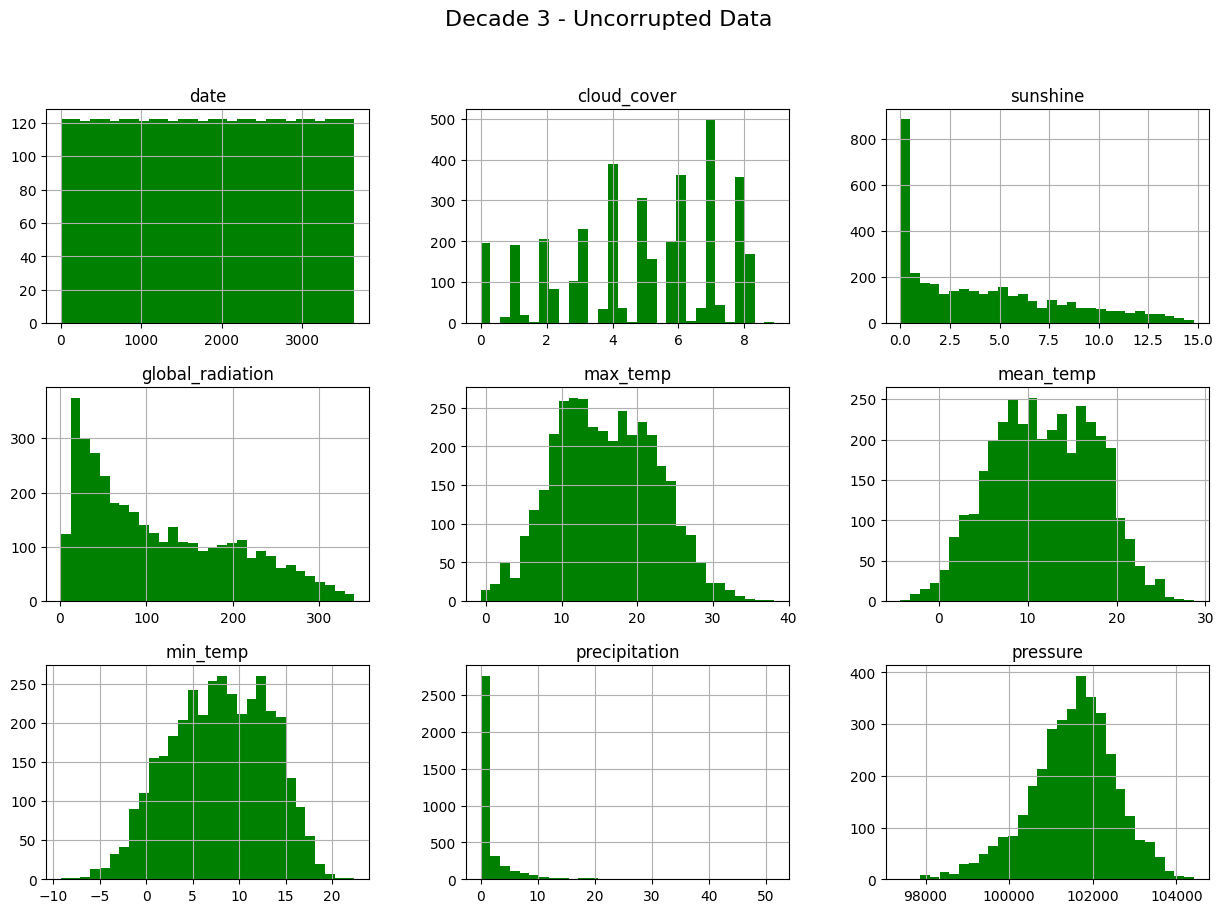

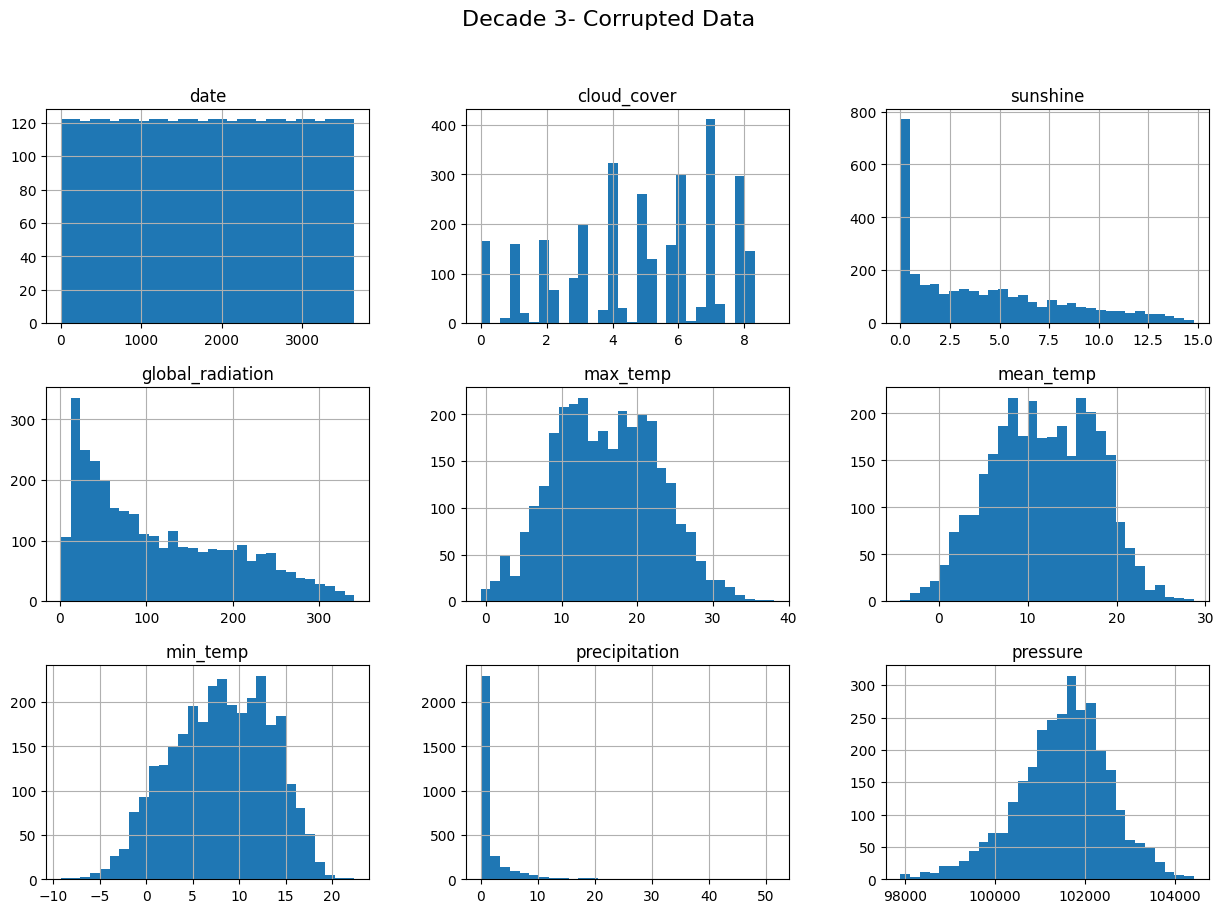

In [308]:
train_set2_uncorrupted.hist(bins=30, figsize=(15, 10), color = "green")
plt.suptitle('Decade 3 - Uncorrupted Data', fontsize=16)
plt.show()
train_set2_corrupted.hist(bins=30, figsize=(15, 10))
plt.suptitle('Decade 3- Corrupted Data', fontsize=16)
plt.show()

Testing dataset - Histograms

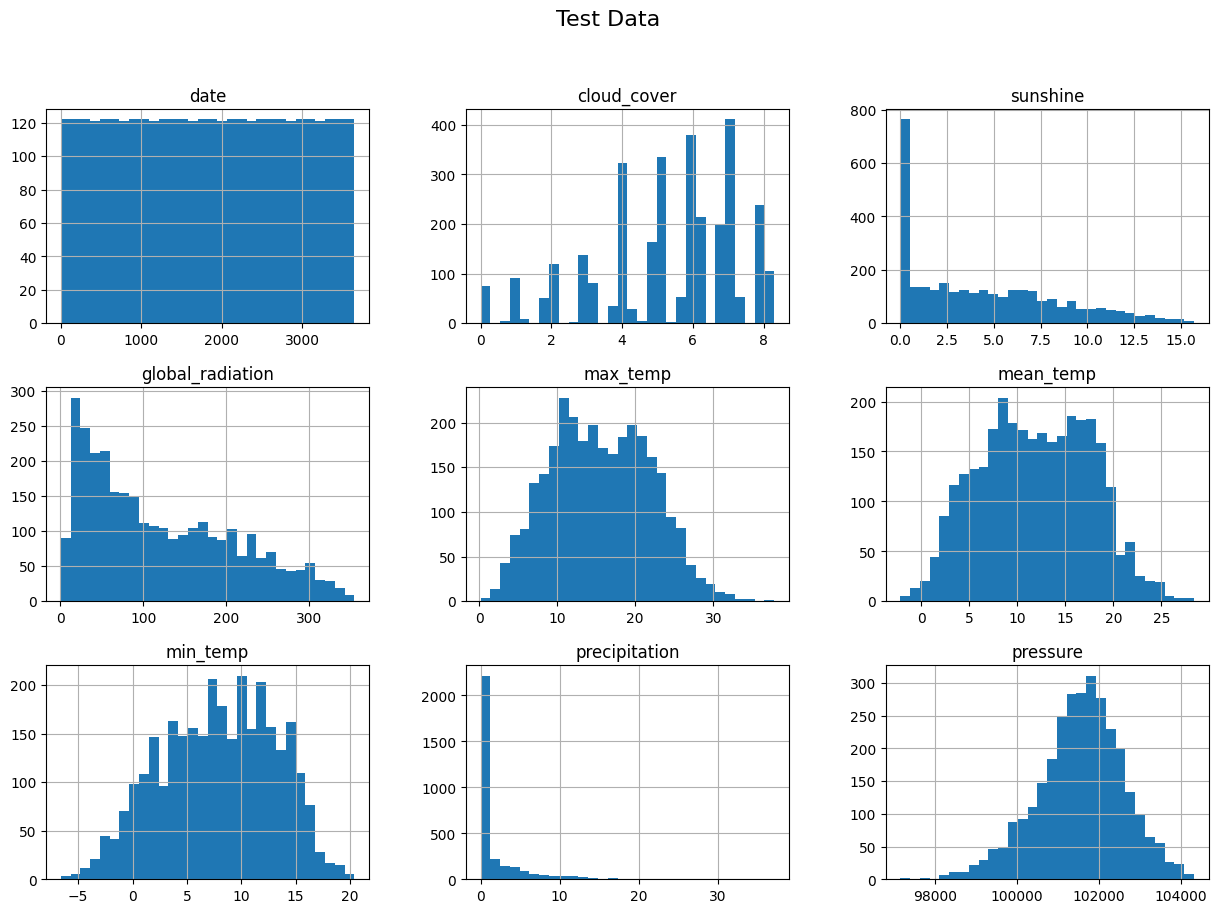

In [309]:
test_set.hist(bins=30, figsize=(15, 10))
plt.suptitle('Test Data', fontsize=16)
plt.show()

Comment on the distributions :
- Overall, all the decades seem to have similar distribution patterns.
- The temperature parameters are roughly uniformly distributed
- Precipitation is heavily concentrated
- Global Radiation is skewed to the left
- cloud cover has irregular distribution
- Sunshine is heavily skewed to the left
- pressure seems fairly normally distributed

In the case of Scaling I would think of doing the following :
- Use standard Scaler on : Temperatures, pressure
- Robust Scaler : Cloud cover, global_radiation, sunshine
- Min Max Scaler : Precipitation

## Step 2: Prepare Data with PyTorch DataLoaders

Convert the datasets into PyTorch `TensorDataset` and `DataLoader` objects:

- Training loader: yields batches of corrupted weather sequences (no labels).  
- Test loader: yields full sequences for reconstruction.  
- Visualize one batch from each loader side by side using line plots.  


Creating the Tensor Dataset and DataLoader for the training dataset

I'll begin by concatenating the training datasets first
1. **training_dataset_corrupt**: training_set0 + training_set1 + training_set2
2. **training_dataset_uncorrupt**: training_set0_nogaps + training_set1_nogaps + training_set2_nogaps    
3. **test_dataset**:  test_set

In [310]:
# creating training_dataset_corrupt
training_dataset_corrupt = pd.concat([train_set0_corrupted, train_set1_corrupted, train_set2_corrupted])
training_dataset_corrupt.shape

(10954, 9)

In [311]:
training_dataset_corrupt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10954 entries, 0 to 3650
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              10954 non-null  int64  
 1   cloud_cover       9112 non-null   float64
 2   sunshine          9266 non-null   float64
 3   global_radiation  9158 non-null   float64
 4   max_temp          9160 non-null   float64
 5   mean_temp         9213 non-null   float64
 6   min_temp          9213 non-null   float64
 7   precipitation     9223 non-null   float64
 8   pressure          9184 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 855.8 KB


In [312]:
# creating training_dataset_uncorrupt
training_dataset_uncorrupt = pd.concat([train_set0_uncorrupted, train_set1_uncorrupted, train_set2_uncorrupted])
training_dataset_uncorrupt.shape

(10954, 9)

In [313]:
training_dataset_uncorrupt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10954 entries, 0 to 3650
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              10954 non-null  int64  
 1   cloud_cover       10954 non-null  float64
 2   sunshine          10954 non-null  float64
 3   global_radiation  10954 non-null  float64
 4   max_temp          10954 non-null  float64
 5   mean_temp         10954 non-null  float64
 6   min_temp          10954 non-null  float64
 7   precipitation     10954 non-null  float64
 8   pressure          10954 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 855.8 KB


In [314]:
train_tensor_dataset = TensorDataset(torch.from_numpy(training_dataset_corrupt.values), torch.from_numpy(training_dataset_uncorrupt.values))
test_tensor_dataset = TensorDataset(torch.from_numpy(test_set.values))

In [315]:
len(train_tensor_dataset)

10954

Creating the DataLoaders

In [316]:
## defining the split size - I am using 95/5 split for training and validation
size_of_dataset = len(train_tensor_dataset)
train_size = int(0.8 * size_of_dataset)
val_size = size_of_dataset - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_tensor_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, num_workers = 0, shuffle = False)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, num_workers = 0, shuffle = False)



In [317]:
test_loader = torch.utils.data.DataLoader(test_tensor_dataset, batch_size = 100, num_workers = 0, shuffle = False)

Using line plots, show here one batch from both the training and test datasets before and after corruption. Use different axis windows for input and label of the batch.



In [318]:
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

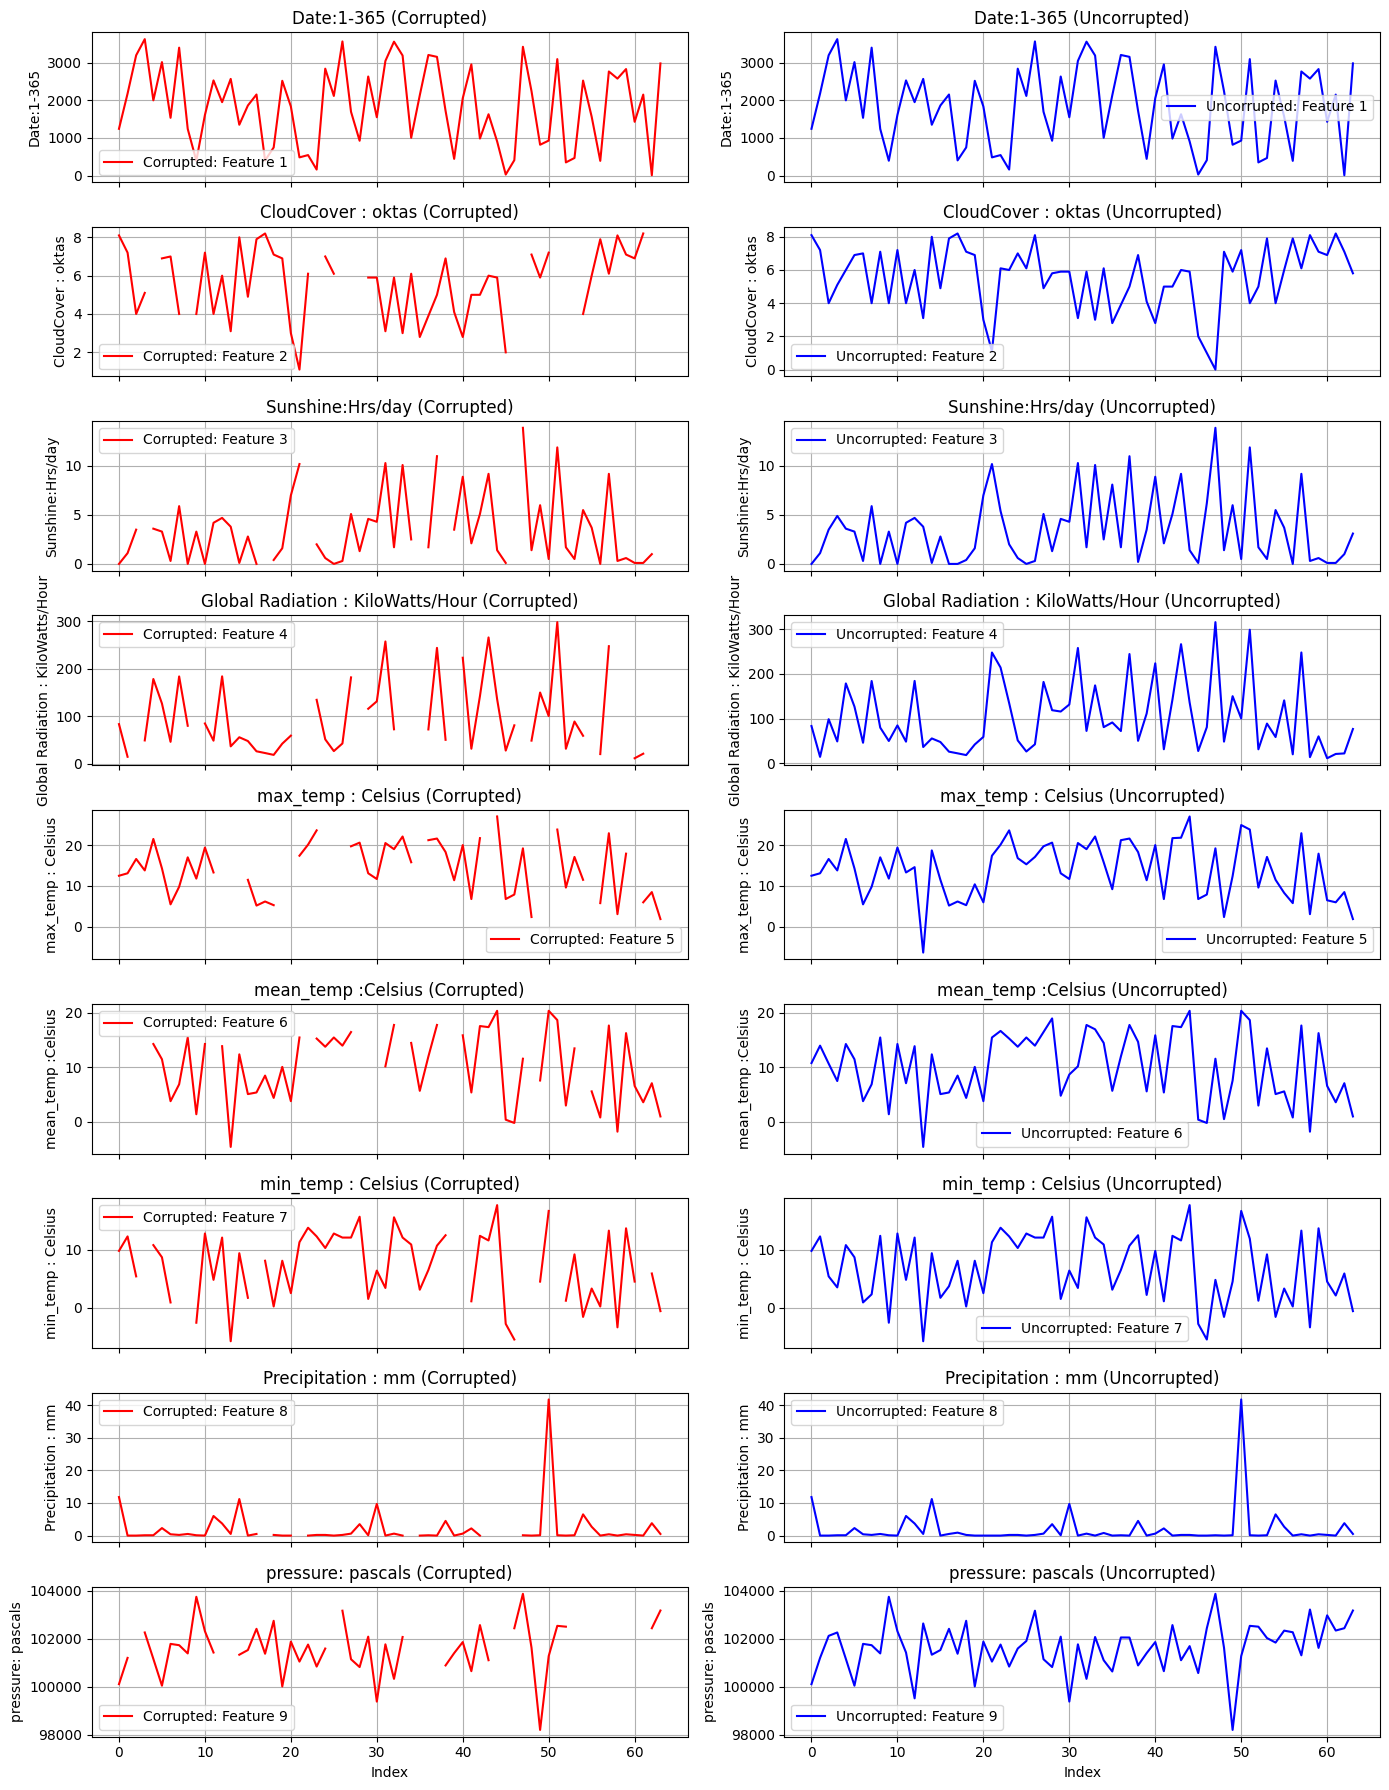

In [319]:
# Assuming train_batch contains corrupted and uncorrupted tensors
corrupted_data, uncorrupted_data = train_batch

# Convert tensors to a DataFrame for easier handling
df_corrupted = pd.DataFrame(corrupted_data.numpy())
df_uncorrupted = pd.DataFrame(uncorrupted_data.numpy())

# Number of variables (columns)
num_variables = df_corrupted.shape[1]

# Create subplots
fig, axes = plt.subplots(num_variables, 2, figsize=(14, 2 * num_variables), sharex=True)

# List of y-axis labels
list_of_y_axis = ["Date:1-365", "CloudCover : oktas",
                  "Sunshine:Hrs/day", "Global Radiation : KiloWatts/Hour", "max_temp : Celsius",
                  "mean_temp :Celsius", "min_temp : Celsius", "Precipitation : mm", "pressure: pascals"]

# Ensure the list matches the number of columns
assert len(list_of_y_axis) >= num_variables, "Y-axis labels must match the number of variables."

# Plot each variable in separate subplots
for i in range(num_variables):
    # Corrupted data plot
    axes[i, 0].plot(range(len(df_corrupted)), df_corrupted[i], label=f'Corrupted: Feature {i+1}', color='red')
    axes[i, 0].set_title(f'{list_of_y_axis[i]} (Corrupted)')
    axes[i, 0].set_ylabel(list_of_y_axis[i])
    axes[i, 0].grid()
    axes[i, 0].legend()

    # Uncorrupted data plot
    axes[i, 1].plot(range(len(df_uncorrupted)), df_uncorrupted[i], label=f'Uncorrupted: Feature {i+1}', color='blue')
    axes[i, 1].set_title(f'{list_of_y_axis[i]} (Uncorrupted)')
    axes[i, 1].set_ylabel(list_of_y_axis[i])
    axes[i, 1].grid()
    axes[i, 1].legend()

# Set shared x-label
axes[-1, 0].set_xlabel('Index')
axes[-1, 1].set_xlabel('Index')

# Adjust layout
fig.tight_layout()
plt.show()


Visualising the first batch of the test data loader

In [320]:
# Convert to DataFrame for easier handling
df_batch = pd.DataFrame(test_batch[0].numpy())

In [321]:
df_batch.shape

(100, 9)

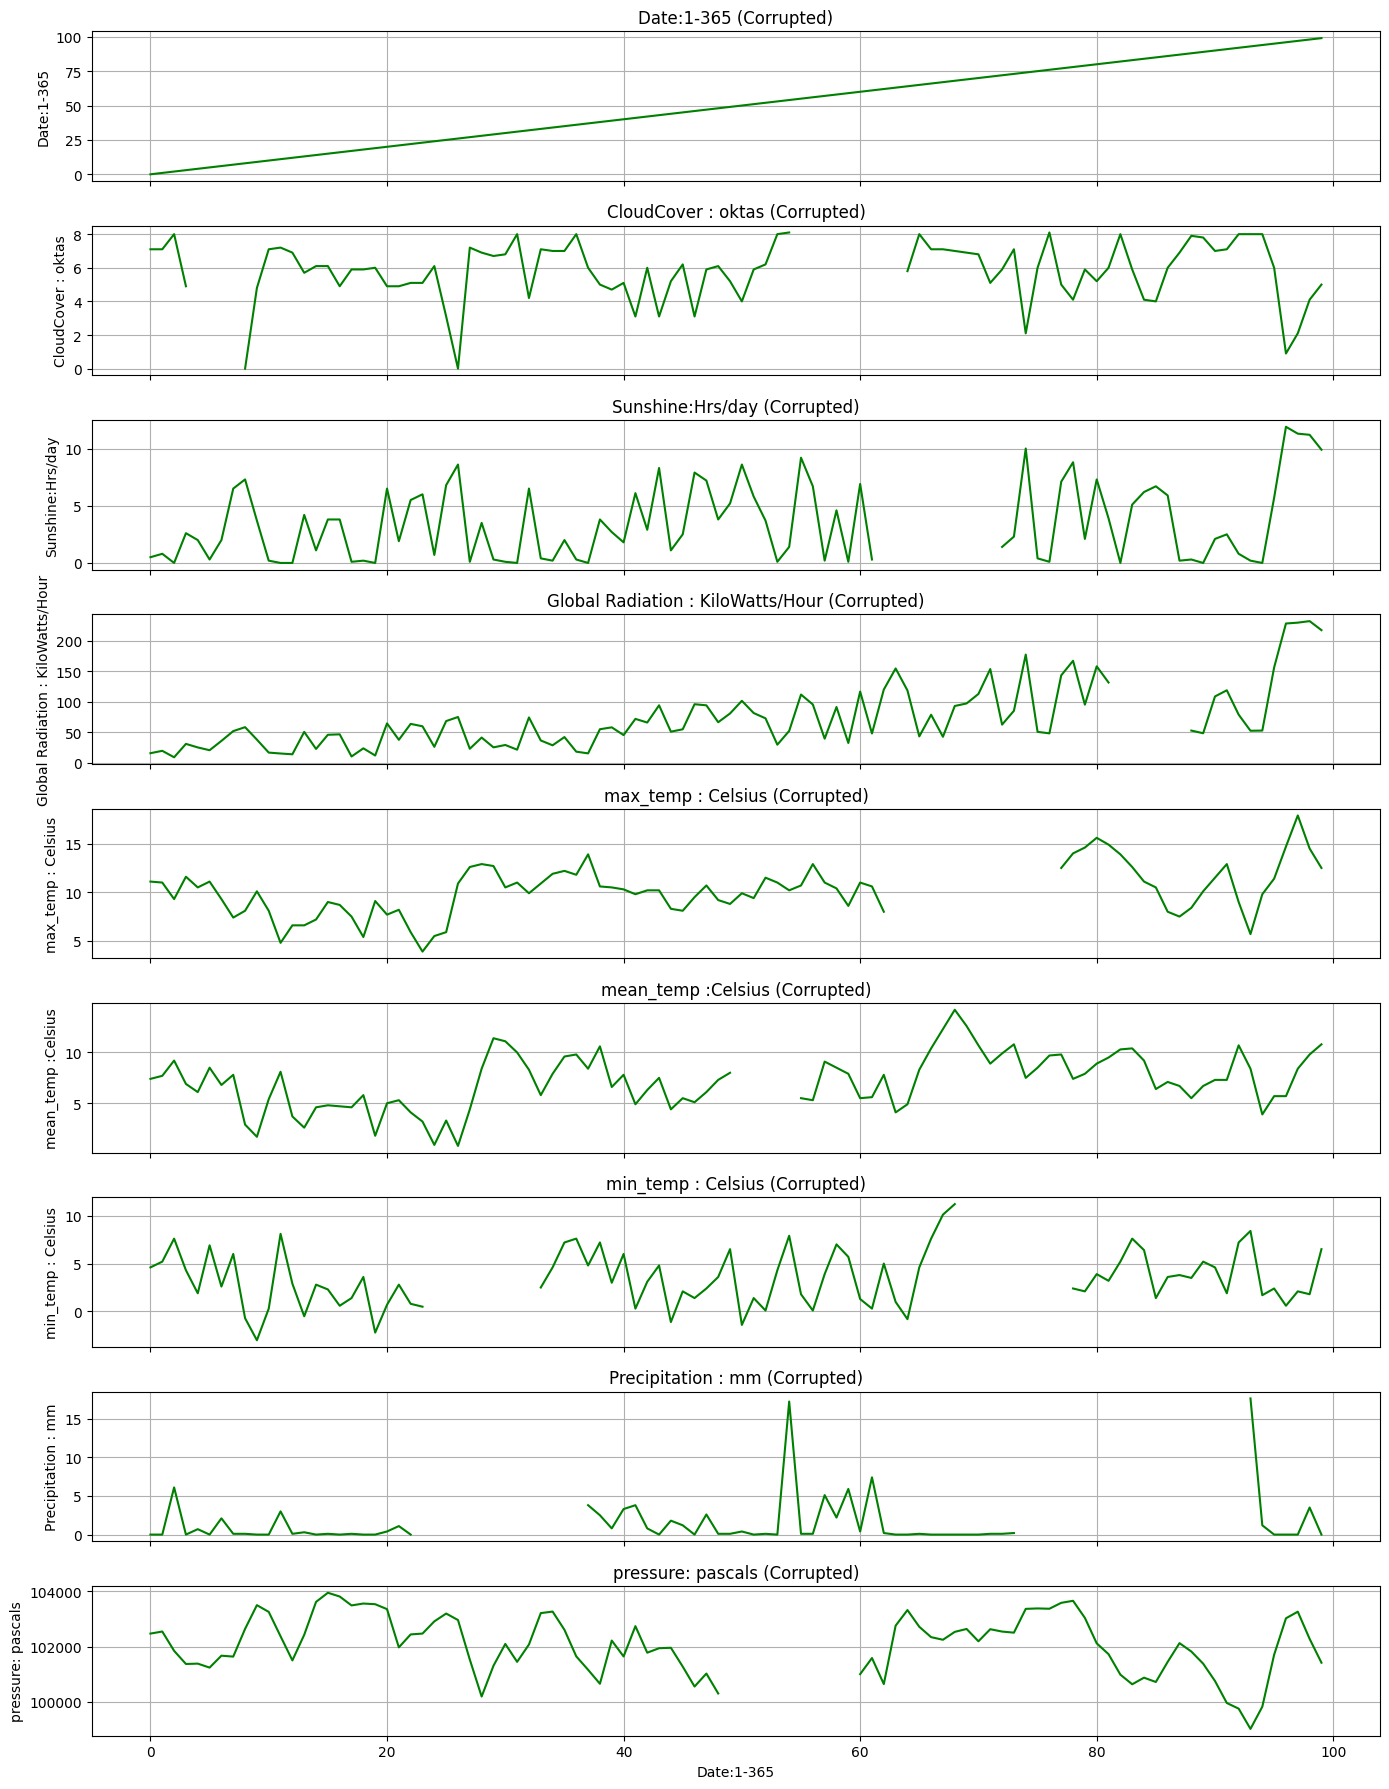

In [322]:
# Number of variables (columns)
num_variables = df_batch.shape[1]

# Create subplots
fig, axes = plt.subplots(num_variables, 1, figsize=(14, 2 * num_variables), sharex=True)

# List of y-axis labels
list_of_y_axis = ["Date:1-365", "CloudCover : oktas",
                  "Sunshine:Hrs/day", "Global Radiation : KiloWatts/Hour", "max_temp : Celsius",
                  "mean_temp :Celsius", "min_temp : Celsius", "Precipitation : mm", "pressure: pascals"]

# Ensure the list matches the number of columns
assert len(list_of_y_axis) >= num_variables, "Y-axis labels must match the number of variables."

# Plot each variable in separate subplots
for i in range(num_variables):
    # Corrupted data plot
    axes[i].plot(range(len(df_batch)), df_batch[i], color='green')
    axes[i].set_title(f'{list_of_y_axis[i]} (Corrupted)')
    axes[-1].set_xlabel(list_of_y_axis[0])
    axes[i].set_ylabel(list_of_y_axis[i])
    axes[i].grid()


# Adjust layout
fig.tight_layout()
plt.show()


## Step 3: Design and Train the Neural Network

Build and train a custom neural network (no pre-trained models) to recover missing values:

- Define the model architecture and training loop.  
- Plot the test sequences with filled-in values in a contrasting color.  
- Save the reconstructed test dataset (same row/column order and headings).  


Data Preprocessing

Steps taken ▶

1. Normalising the dataset - using z-score normalisation, it is a simple standard way to go. Normalising is for the purpose of model training, and handling the varying scales
2. setting the sequence length - when working with time-series data and LSTMS sequence lengths are created as a mean of a window that works as chunks to work on. 30 because I wanted to start with a small value (taking it monthly~30 days)
3. divinding the input and target values (__getitem__)

In [323]:
# import torch
from torch.utils.data import Dataset

class WeatherDataset(Dataset):
    def __init__(self, corrupted, uncorrupted, sequence_length=30):
        # Compute mean and std for normalization
        self.mean = corrupted.mean(dim=0, keepdim=True)
        self.std = corrupted.std(dim=0, keepdim=True)
        self.sequence_length = sequence_length

        # Normalize corrupted and uncorrupted tensors
        # Using standard z-score normalisation formula : (x - mean) / st dev.
        self.corrupted = (corrupted - self.mean) / self.std
        self.uncorrupted = (uncorrupted - self.mean) / self.std

    def __len__(self):
        return len(self.corrupted) - self.sequence_length

    def __getitem__(self, idx):
        x = self.corrupted[idx : idx + self.sequence_length]
        y = self.uncorrupted[idx : idx + self.sequence_length]
        return x, y


In [324]:
# beginning with loading the train and test dataset
# I have training dataset and testing dataset in the form of tensors
# just to simplify my fill na values and sequencing process, I plan on converting them back to a pandas dataframe

# training_tensor_dataset = pd.DataFrame(train_tensor_dataset.tensors[0].numpy())
# training_dataset_uncorrupt = pd.DataFrame(train_tensor_dataset.tensors[1].numpy())



In [325]:
# training_tensor_dataset.shape

In [326]:
# # Example training and test tensors
# train_corrupted = torch.rand((1000, 10))  # Simulated data
# train_uncorrupted = train_corrupted + 0.1 * torch.randn_like(train_corrupted)  # Add small noise

# test_tensor = torch.rand((500, 10))  # Simulated test data
# test_tensor[torch.rand_like(test_tensor) < 0.1] = float('nan')  # Simulate missing values

# # Fill NaN values in test tensor
# test_tensor_filled = torch.nan_to_num(test_tensor, nan=0.0)

# # Create dataset
# sequence_length = 30
# train_dataset = WeatherDataset(train_corrupted, train_uncorrupted, sequence_length)

# # Example: Access one item
# x, y = train_dataset[0]
# print("First Normalized Corrupted:", x[0])
# print("First Normalized Uncorrupted:", y[0])


Normalising the Training Dataset

In [327]:
# Extract tensors
corrupted, uncorrupted = train_tensor_dataset.tensors

# Handle NaN values in the input data  - as I got an error of all Nan values while normalising the dataset
corrupted = torch.nan_to_num(corrupted, nan=0.0)
uncorrupted = torch.nan_to_num(uncorrupted, nan=0.0)
train_tensor_dataset = TensorDataset(corrupted, uncorrupted)
# Sequence length : A sequence length of 30 may represent a reasonable time window (e.g., daily data for one month) for capturing such trends.
sequence_length = 30

# Compute normalization statistics
mean = corrupted.float().mean(dim=0, keepdim=True)
std = corrupted.float().std(dim=0, keepdim=True)

# Handling zero std - as I got a error of all NaN values while normalising the dataset
std[std == 0] = 1

# Getting the length of the dataset
dataset_length = len(train_tensor_dataset) - sequence_length

# Example: Accessing a specific item
idx = 0  # Index of the sequence

# Normalize and extract sequence
normalised_corrupt = (corrupted[idx : idx + sequence_length].float() - mean) / std
normalised_uncorrupt = (uncorrupted[idx : idx + sequence_length].float() - mean) / std

train_tensor_dataset = TensorDataset(normalised_corrupt, normalised_uncorrupt)
print("First Normalized Corrupted Sequence with no missing values :", normalised_corrupt[0])
print("First Normalized Uncorrupted Sequence with no missing values :", normalised_uncorrupt[0])

First Normalized Corrupted Sequence with no missing values : tensor([-1.7315, -0.1349, -0.8624, -0.9587, -1.2958, -1.6131, -1.8609, -0.3978,
         0.4321])
First Normalized Uncorrupted Sequence with no missing values : tensor([-1.7315, -0.1349, -0.8624, -0.9587, -1.2958, -1.6131, -1.8609, -0.3978,
         0.4321])


With the normalised data I want to create the DataLoader for training and vaidation again

inference to think of : can I split the data without doing it randomly ?*

Probably train on 2 decades, and validation on the 3rd

In [331]:
# Extract tensors
corrupted, uncorrupted = train_tensor_dataset.tensors

# Handle NaN values in the input data  - as I got an error of all Nan values while normalising the dataset
corrupted = torch.nan_to_num(corrupted, nan=0.0)
uncorrupted = torch.nan_to_num(uncorrupted, nan=0.0)
train_tensor_dataset = TensorDataset(corrupted, uncorrupted)
# Sequence length : A sequence length of 30 may represent a reasonable time window (e.g., daily data for one month) for capturing such trends.
sequence_length = 30

# Compute normalization statistics
mean = corrupted.float().mean(dim=0, keepdim=True)
std = corrupted.float().std(dim=0, keepdim=True)

# Handling zero std - as I got a error of all NaN values while normalising the dataset
std[std == 0] = 1

# Getting the length of the dataset
dataset_length = len(train_tensor_dataset) - sequence_length

# Example: Accessing a specific item
idx = 0  # Index of the sequence

# Normalize and extract sequence
normalised_corrupt = (corrupted[idx : idx + sequence_length].float() - mean) / std
normalised_uncorrupt = (uncorrupted[idx : idx + sequence_length].float() - mean) / std

train_tensor_dataset = TensorDataset(normalised_corrupt, normalised_uncorrupt)
print("First Normalized Corrupted Sequence with no missing values :", normalised_corrupt[0])
print("First Normalized Uncorrupted Sequence with no missing values :", normalised_uncorrupt[0])

First Normalized Corrupted Sequence with no missing values : tensor([-1.6471,  0.1880, -0.8896, -0.6004, -1.4565, -1.1370, -1.3234, -0.3314,
        -0.2340])
First Normalized Uncorrupted Sequence with no missing values : tensor([-1.6471,  0.1880, -0.8896, -0.6004, -1.4565, -1.1370, -1.3234, -0.3314,
        -0.2340])


In [ ]:
# do a simple split without randomly splitting it

# Get the size of the dataset
size_of_dataset = len(train_tensor_dataset)

# Define 80/20 split sizes
train_size = int(0.8 * size_of_dataset)
val_size = size_of_dataset - train_size

# Ensure the sizes add up correctly
assert train_size + val_size == size_of_dataset, "Split sizes do not match dataset size."

# Define indices for train and validation splits
train_indices = list(range(train_size))  # First 80% of data
val_indices = list(range(train_size, size_of_dataset))  # Remaining 10% of data

# Create subsets for training and validation
train_dataset = Subset(train_tensor_dataset, train_indices)
val_dataset = Subset(train_tensor_dataset, val_indices)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

# Verify sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

## Debugged using ChatGPT

Train size: 24, Validation size: 6


The model I am using is LSTM :     
Why ?
1. Simplicity : In comparison to the complicated process of transformers, its a simpler, compact process
2. Why not RNN : Accoding to me, RNN would be unstable for long sequenced data
3. LSTMS's strength to model time series data: its great to handle sequential data effectively as the structure of it takes the previous data , filters the significant pattern and implement it on the next data. Just like weather data.

Defining the LSTM Model

init :
   - Takes the number of input features (`input_dim`), LSTM hidden units total  (`hidden_dim`), and the number of layers in LSTM(`num_layers`).

defining the LSTM Layer:
     - `input_dim`: input features per time step.
     - `hidden_dim`: hidden units in each LSTM step.
     - `num_layers`: No of  LSTM layers stacked together.


4. self.fc = nn.Linear(hidden_dim, input_dim)*  
   - Fully connected (linear) layer to map LSTM outputs back to the input feature space:
     - Input: Hidden state output from LSTM (`hidden_dim`).
     - Output: Predicted values matching the input dimension (`input_dim`).

---

- in the Forward Method :
5. lstm_out, _ = self.lstm(x)  
   - Passes the input `x` through the LSTM layer:
     - `lstm_out`: Contains the sequence of hidden states for all time steps.
     - `_`: the final hidden and cell states, which are not used here.

6. predictions = self.fc(lstm_out)  
   - Applies the fully connected layer to each hidden state in `lstm_out`, producing predictions for each time step and feature.


---

Summarisimng what its doing *
- **LSTM Layer**: Captures temporary dependencies in the input data.
- **Fully Connected Layer**: Transforming the LSTM total outputs to predict missing values for the input features at each time step.


In [333]:
class LSTMImputer(nn.Module):
    def __init__(self, input_dim, hidden_layer_dim, num_layers=1):
        super(LSTMImputer, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_layer_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_dim, input_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out)
        return predictions

Training the LSTM Model

In [334]:
# Model parameters
input_dim = train_set0_corrupted.shape[1]  # Number of weather features
hidden_dim = 64
num_layers = 1
num_epochs = 350
learning_rate = 0.001

# Initialize the model
model = LSTMImputer(input_dim, hidden_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



ATTEMPT 1 - Got all NaN values for the Loss Function

In [335]:
# debug - checking for nan values in the train values
nan_count = 0
for tensors in train_tensor_dataset:
    for tensor in tensors:
        nan_count += torch.isnan(tensor).sum().item()

print(f"Total NaN values in the dataset: {nan_count}")


Total NaN values in the dataset: 0


In [336]:
# debug - checking for nan values in the train values
nan_count = 0
for tensors in train_tensor_dataset:
    for tensor in tensors:
        nan_count += torch.isnan(tensor).sum().item()

print(f"Total NaN values in the dataset: {nan_count}")


Total NaN values in the dataset: 0


Debugged and done :)

Training and Validation

Keeping both the processes in one loop,

In [337]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
validation_losses = []

# Training loop with validation and learning curve tracking
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0
    for corrupted, uncorrupted in train_loader:
        optimizer.zero_grad()
        corrupted = corrupted.float()
        uncorrupted = uncorrupted.float()
        output = model(corrupted)
        loss = criterion(output, uncorrupted)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store train loss

    # Validation Phase
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for corrupted, uncorrupted in val_loader:
            corrupted = corrupted.float()
            uncorrupted = uncorrupted.float()
            output = model(corrupted)
            loss = criterion(output, uncorrupted)
            validation_loss += loss.item()

    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)  # Store validation loss

    # Print Epoch Metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")



Epoch 1/350, Train Loss: 0.9524, Validation Loss: 1.0239
Epoch 2/350, Train Loss: 0.9402, Validation Loss: 1.0188
Epoch 3/350, Train Loss: 0.9282, Validation Loss: 1.0138
Epoch 4/350, Train Loss: 0.9163, Validation Loss: 1.0087
Epoch 5/350, Train Loss: 0.9045, Validation Loss: 1.0037
Epoch 6/350, Train Loss: 0.8928, Validation Loss: 0.9987
Epoch 7/350, Train Loss: 0.8811, Validation Loss: 0.9936
Epoch 8/350, Train Loss: 0.8693, Validation Loss: 0.9886
Epoch 9/350, Train Loss: 0.8575, Validation Loss: 0.9835
Epoch 10/350, Train Loss: 0.8456, Validation Loss: 0.9784
Epoch 11/350, Train Loss: 0.8335, Validation Loss: 0.9732
Epoch 12/350, Train Loss: 0.8212, Validation Loss: 0.9681
Epoch 13/350, Train Loss: 0.8087, Validation Loss: 0.9629
Epoch 14/350, Train Loss: 0.7961, Validation Loss: 0.9577
Epoch 15/350, Train Loss: 0.7832, Validation Loss: 0.9525
Epoch 16/350, Train Loss: 0.7702, Validation Loss: 0.9472
Epoch 17/350, Train Loss: 0.7570, Validation Loss: 0.9418
Epoch 18/350, Train Los

Use this code to create the learning curve
(from transformers)

I wanted to use the live loss plot, but due to the lack of time I was not able to ( as I was faced with errors )

In [338]:
# # # Create model and send to device
# # model = TextTransformer(
# #     embed_dim=96, num_classes=4, patch_size=2,
# #     num_layers=1, num_heads=8, mlp_ratio=2, seq_pool=True,
# #     vocab=glove_vocab, pretrained_embeddings=pretrained_embeddings
# # ).to(device)

# # set_seed(seed)

# # optimizer = torch.optim.Adam(model.parameters(), lr=lr)   # instantiate the optimizer
# # criterion = nn.CrossEntropyLoss()                         # instantiate the criterion

# # # Create data loaders
# # train_loader = DataLoader(split_train, batch_size=batch_size, num_workers=0, shuffle=True, collate_fn=collate_batch)
# # valid_loader = DataLoader(split_valid, batch_size=test_batch_size, num_workers=0, shuffle=False, collate_fn=collate_batch)
# # test_loader = DataLoader(agnews_test, batch_size=test_batch_size, num_workers=0, shuffle=False, collate_fn=collate_batch)

# liveloss = PlotLosses()    # plots evolution of loss and accuracy
# for epoch in range(num_epochs):
#     logs = {}
#     train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

#     logs['' + 'log loss'] = train_loss.item()
#     logs['' + 'accuracy'] = train_accuracy

#     validation_loss, validation_accuracy = validate(model, criterion, valid_loader)
#     logs['val_' + 'log loss'] = validation_loss.item()
#     logs['val_' + 'accuracy'] = validation_accuracy

#     liveloss.update(logs)
#     liveloss.draw()
#     print(validation_loss.item())

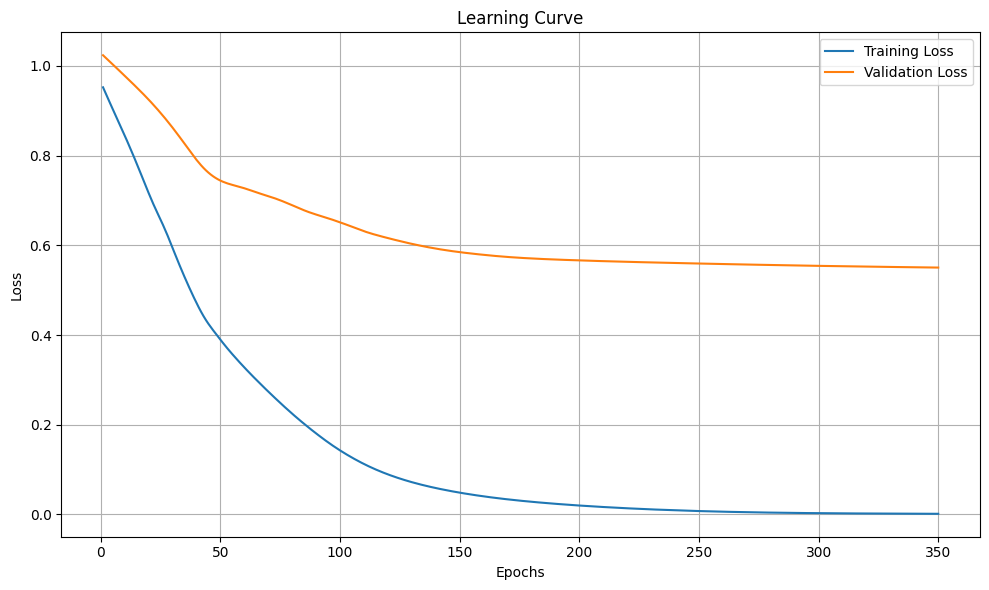

In [339]:

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Predict

In [340]:
# Evaluation/Prediction Phase for Test Data
model.eval()  # Set model to evaluation mode
predictions = []

with torch.no_grad():  # Disable gradient computation for inference
    for batch_index, corrupted_batch in enumerate(test_loader):  # Only corrupted data in test_loader
        #corrupted = corrupted.float() # Ensure data type and move to device
      # corrupted_batch = torch.stack([torch.tensor(data, dtype = torch.float32) for data in corrupted_batch[0]])
        corrupted_batch = torch.stack([data.clone().detach().float() for data in corrupted_batch[0]]) ## debugged using ChatGPT
        # Handle missing values (replace NaN with 0 or another placeholder)
        corrupted_batch = torch.nan_to_num(corrupted_batch, nan=0.0)

        # Pass data through the model
        output = model(corrupted_batch)

        # Apply post-processing (if necessary)
        predictions.append(output)  # Move predictions to CPU for storage

# Concatenate all predictions
predictions = torch.cat(predictions, dim=0)

# Save predictions to a CSV
filled_df = pd.DataFrame(predictions.numpy())
filled_df.to_csv("test_set_nogaps.csv", index=False, header=True)

print("Predictions saved to 'test_set_nogaps.csv'")


Predictions saved to 'test_set_nogaps.csv'


Visualise

I faced an error where my output dataset was filled with Tensor data ( I was unable to debug that due to the lack of time (as always:))

KeyError: 'date'

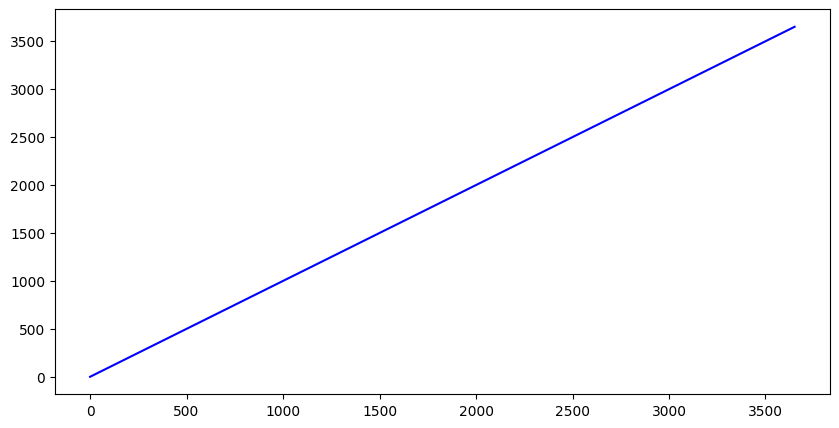

In [341]:
import matplotlib.pyplot as plt
result = pd.read_csv("test_set_nogaps.csv")
for column in test_set.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(test_set.index, test_set[column], label="Original Data (with gaps)", color="blue")
    plt.plot(result.index, result[column], label="Filled Data", color="orange")
    plt.title(f"{column} - Missing Value Imputation")
    plt.legend()
    plt.grid()
    plt.show()


## Conclusion and Future Work

Summarize model performance and outline areas for improvement:

- Potential hyperparameter tuning strategies.  
- Ideas for deploying the model or extending to other cities.  
- Any additional analyses you’d pursue with more time.  


<br>

---

<br>